# Sleep Event Detection Project

<!-- TOC -->
- [Introduction](#introduction)
- [Objective](#objective)
  - [Hypotheses](#hypotheses)
  - [Analysis](#analysis)
  - [Data Annotation Guidelines](#data-annotation-guidelines)
  - [Dataset Overview](#dataset-overview)
  - [Feature Dictionary](#feature-dictionary)
  - [Acknowledgments](#acknowledgements)
  - [Data Availability](#data-availability)
- [Memory reduction](#memory-reduction)
- [Data Exploration](#data-exploration)
  - [Data resampling](#resampling-data-to-1-minute-intervals)
  - [Summary](#data-exploration-summary)


# Introduction

This project focuses on developing a model for sleep event detection using wrist-worn accelerometer data. The goal is to accurately identify sleep onset and wake periods, enabling researchers to conduct large-scale sleep studies and gaining insights into the relationship between sleep, mood, and behavior.

# Objective

The primary objective is to create a model that can analyze accelerometer data and detect sleep events, specifically onset and wake, with high precision. This model has potential applications in improving sleep studies, especially for children with mood and behavior difficulties.

## Hypotheses

1. Occurrences of NaNs in the train_event.csv file align with periods when the wristband was not worn.
2. Investigate the distinctions between complete and incomplete event labels.
3. There are periods of duplicate data in the series data for some series.
4. Daylight Saving Time/local vs. UTC has minimal to no discernible effect on the data.
5. There exist consistent hours/times when children initiate sleep and wake up.
6. Sleep duration patterns exhibit similarity across different participants.
7. Euclidean Norm Minus One (ENMO) and anglez can reliably determine the difference between sleep and awake phases.

## Analysis

1. **Data Exploration:** Understand the dataset's structure, explore variable distributions, and identify potential patterns or outliers.
2. **Data Preprocessing:** Clean the data, handle missing values, and prepare it for modeling.
3. **Exploratory Data Analysis (EDA):** Tackle the hypotheses by visually examining relationships between variables, extracting meaningful insights and patterns.
4. **Conlusion:** Conclusively, the dataset exploration has revealed key patterns and outliers, guiding our understanding of the data and providing a foundation for informed model development.

## Data Annotation Guidelines

- Sleep events are defined as onset (beginning of sleep) and wake (end of sleep).
- Each sleep period must be at least 30 minutes in length.
- Sleep periods can be interrupted by short bouts of activity (not exceeding 30 consecutive minutes).
- No sleep windows can be detected unless the wrist-worn device is deemed to be worn for the duration.
- Only the longest sleep window during the night is recorded.
- No more than one window should be assigned per night.

## Dataset Overview

The dataset includes:

- **train_series.parquet:** Training data with accelerometer recordings for multiple subjects.
- **test_series.parquet:** Test data for predicting sleep events.
- **train_events.csv:** Sleep logs for training series, recording onset and wake events.

## Feature Dictionary

| Feature   | Description                                             |
|-----------|---------------------------------------------------------|
| series_id | Unique identifier for each accelerometer series.        |
| step      | Integer timestep for each observation within a series.  |
| timestamp | Datetime with ISO 8601 format.                          |
| anglez    | Angle of the arm relative to the vertical axis.         |
| enmo      | Euclidean Norm Minus One of all accelerometer signals. |

## Acknowledgements

This Code Competition is in collaboration with the Child Mind Institute, aiming to advance research in children's mental health. The dataset, provided by the Healthy Brain Network, supports the goal of improving sleep studies and understanding the impact of sleep on mental health. The competition is made possible by the Stavros Niarchos Foundation (SNF) Global Center for Child and Adolescent Mental Health.

## Data Availability

The dataset and competition details are available on [Kaggle](https://www.kaggle.com/competitions/child-mind-institute-detect-sleep-states/overview).

In [20]:
# importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import polars as pl
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import seaborn as sns
import missingno as msno
from pandas.api.types import is_datetime64_ns_dtype
import gc  # garbage collector module

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.offline
import pyarrow.parquet as pq

import kaleido
import os
from IPython.display import Image, display

from plots import plot_series_with_events

import warnings
warnings.filterwarnings("ignore")  # ignore any warnings in the code execution

# Memory reduction

In [23]:
# define the common path
# change this to your local path
path = 'gs://sleep-nov2023/data/'

In [24]:
%%time

# Read data from the specified parquet file, parse the timestamp column to datetime, and convert to pandas DataFrame
train_series = (
    pl.scan_parquet(path + 'original_data/train_series.parquet')  # Read data from the parquet file
    .with_columns(
        (
            (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),  # Parse timestamp to datetime / change %Z into %z for keeping
        )
    )
    .collect()  # Collect the Polars DataFrame
    .to_pandas()  # Convert to pandas DataFrame
)

CPU times: user 1min 4s, sys: 15.6 s, total: 1min 19s
Wall time: 53.1 s


In [25]:
# Display information about the DataFrame
train_series.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127946340 entries, 0 to 127946339
Data columns (total 5 columns):
 #   Column     Dtype         
---  ------     -----         
 0   series_id  object        
 1   step       uint32        
 2   timestamp  datetime64[us]
 3   anglez     float32       
 4   enmo       float32       
dtypes: datetime64[us](1), float32(2), object(1), uint32(1)
memory usage: 3.3+ GB


The following function has been taken from the notebook 
<a 
   href=https://www.kaggle.com/code/renatoreggiani/feat-eng-ideas-60-memory-reduction-cmi>
    🛠Feat Eng ideas & 60% memory reduction 🛠- CMI
</a>. Thanks to Renato Reggiani.

In [26]:
# Define a function to reduce memory usage of a DataFrame
def reduce_mem_usage(df):
    """ 
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.        
    """
    
    # Display the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage of dataframe is {start_mem:.2f} MB')
    
    # Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column is not an object type and not a datetime64 type
        if col_type != object and not np.issubdtype(df[col], np.datetime64):
            c_min = df[col].min()
            c_max = df[col].max()

            # Check if the column is of integer type
            if str(col_type)[:3] == 'int':
                # Check the range of values to determine the smallest integer type that can be used
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                # If the column is of floating-point type, determine the smallest type that can be used
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        
    # Convert the 'series_id' column to the categorical type
    df['series_id'] = df['series_id'].astype('category')

    # Display the memory usage after optimization
    end_mem = df.memory_usage().sum() / 1024**2
    print(f'Memory usage after optimisation is: {end_mem:.2f} MB')
    
    # Calculate and display the percentage decrease in memory usage
    decrease = 100 * (start_mem - end_mem) / start_mem
    print(f'Decreased by {decrease:.2f}%')
    
    # Return the optimized DataFrame
    return df


In [27]:
# this line calls the 'reduce_mem_usage' function
# to optimize the memory usage of the 'train_series' DataFrame and assigns the result back to 'train_series'
# the 'reduce_mem_usage' function is expected to be defined before this line in the code
train_series = reduce_mem_usage(train_series)

Memory usage of dataframe is 3416.54 MB
Memory usage after optimisation is: 2684.43 MB
Decreased by 21.43%


In [28]:
# calculate the memory usage of the 'train_series' DataFrame in megabytes (MB)
# the 'memory_usage()' function returns the memory usage for each column in bytes,
# and dividing by 1024**2 converts it to megabytes (MB).
train_series.memory_usage() / 1024**2

Index          0.000122
series_id    244.048302
step         488.076553
timestamp    976.153107
anglez       488.076553
enmo         488.076553
dtype: float64

In [29]:
# display the first few rows of the 'train_series' DataFrame
# the 'head()' function is used to retrieve the top rows (by default, the first 5 rows) of the DataFrame
train_series.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0.0,2018-08-14 15:30:00,2.6367,0.0217
1,038441c925bb,1.0,2018-08-14 15:30:05,2.6368,0.0215
2,038441c925bb,2.0,2018-08-14 15:30:10,2.6370,0.0216
3,038441c925bb,3.0,2018-08-14 15:30:15,2.6368,0.0213
4,038441c925bb,4.0,2018-08-14 15:30:20,2.6368,0.0215


In [32]:
# scan the CSV file and create a polars DataFrame
train_events = (pl.scan_csv(path + 'original_data/train_events.csv')
                
                # Perform column-wise transformations
                .with_columns(
                    (
                        # Convert the 'timestamp' column to datetime format
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                        
                        # Extract year from the 'timestamp' column
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.year().alias("year")),
                        
                        # Extract month from the 'timestamp' column
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.month().alias("month")),
                        
                        # Extract day from the 'timestamp' column
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.day().alias("day")),
                        
                        # Extract hour from the 'timestamp' column
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z").dt.hour().alias("hour")),
                    )
                )
                
                # Collect the polars DataFrame
                .collect()
                
                # Convert the collected data to a Pandas DataFrame
                .to_pandas()
               )

FileNotFoundError: No such file or directory (os error 2): gs://sleep-nov2023/data/original_data/train_events.csv

In [ ]:
# display the first few rows of the 'train_events' DataFrame
# the 'head()' function is used to retrieve the top rows (by default, the first 5 rows) of the DataFrame
train_events.head()

In [33]:
%%time
# read a Parquet file located at the specified path using polars (pl) library,
# then perform a series of data transformations, and finally convert it to a Pandas DataFrame

# scan the Parquet file and create a polars DataFrame
test_series = (pl.scan_parquet(path + 'original_data/test_series.parquet')
                
                # Perform column-wise transformations
                .with_columns(
                    (
                        # Convert the 'timestamp' column to datetime format
                        (pl.col("timestamp").str.strptime(pl.Datetime, "%Y-%m-%dT%H:%M:%S%Z")),
                    )
                )
                
                # Collect the polars DataFrame
                .collect()
                
                # Convert the collected data to a Pandas DataFrame
                .to_pandas()
               )


CPU times: user 8.21 ms, sys: 12.2 ms, total: 20.4 ms
Wall time: 121 ms


In [34]:
# optimize the memory usage of the 'test_series' DataFrame and assigns the result back to 'test_series'
# the 'reduce_mem_usage' function is expected to be defined before this line in the code
test_series = reduce_mem_usage(test_series)

Memory usage of dataframe is 0.01 MB
Memory usage after optimisation is: 0.01 MB
Decreased by 23.71%


In [37]:
# write the 'train_series' DataFrame to a Parquet file at the specified path,
# saving the memory-optimized version of the DataFrame
train_series.to_parquet(path + 'memory_optimised_data/train_series_mem_optimised.parquet')

# write the 'train_events' DataFrame to a Parquet file at the specified path,
# saving the memory-optimized version of the DataFrame
# train_events.to_parquet(path + 'memory_optimised_data/train_events_mem_optimised.parquet')

# write the 'test_series' DataFrame to a Parquet file at the specified path,
# saving the memory-optimized version of the DataFrame
test_series.to_parquet(path + 'memory_optimised_data/test_series_mem_optimised.parquet')

# Data Exploration

In [38]:
# reading a Parquet file
train_series = pd.read_parquet(path + 'memory_optimised_data/train_series_mem_optimised.parquet')

In [39]:
# displaying the first few rows of the DataFrame
train_series.head()

,series_id,step,timestamp,anglez,enmo
0,038441c925bb,0.0,2018-08-14 15:30:00,2.6367,0.0217
1,038441c925bb,1.0,2018-08-14 15:30:05,2.6368,0.0215
2,038441c925bb,2.0,2018-08-14 15:30:10,2.6370,0.0216
3,038441c925bb,3.0,2018-08-14 15:30:15,2.6368,0.0213
4,038441c925bb,4.0,2018-08-14 15:30:20,2.6368,0.0215


In [40]:
# displaying the shape (number of rows and columns)
shape1 = train_series.shape
print(f"The 'train_series' DataFrame has {shape1[0]} rows and {shape1[1]} columns.")

The 'train_series' DataFrame has 127946340 rows and 5 columns.


In [41]:
# checking for missing values in each column and summing them up
train_series.isna().sum()

series_id    0
step         0
timestamp    0
anglez       0
enmo         0
dtype: int64

This indicates that there are no missing values in any of the columns of the 'train_series' DataFrame.

In [42]:
# reading a Parquet file
train_events = pd.read_parquet(path + 'memory_optimised_data/train_events_mem_optimised.parquet')

In [43]:
# displaying the first few rows of the DataFrame
train_events.head()

,series_id,night,event,step,timestamp,year,month,day,hour
0,038441c925bb,1,onset,4992.0,2018-08-14 22:26:00,2018.0,8.0,14.0,22.0
1,038441c925bb,1,wakeup,10932.0,2018-08-15 06:41:00,2018.0,8.0,15.0,6.0
2,038441c925bb,2,onset,20244.0,2018-08-15 19:37:00,2018.0,8.0,15.0,19.0
3,038441c925bb,2,wakeup,27492.0,2018-08-16 05:41:00,2018.0,8.0,16.0,5.0
4,038441c925bb,3,onset,39996.0,2018-08-16 23:03:00,2018.0,8.0,16.0,23.0


In [44]:
# displaying the shape (number of rows and columns)
shape2 = train_events.shape
print(f"The 'train_events' DataFrame has {shape2[0]} rows and {shape2[1]} columns.")

The 'train_events' DataFrame has 14508 rows and 9 columns.


In [45]:
# checking for missing values in each column and summing them up
train_events.isna().sum()

series_id       0
night           0
event           0
step         4923
timestamp    4923
year         4923
month        4923
day          4923
hour         4923
dtype: int64

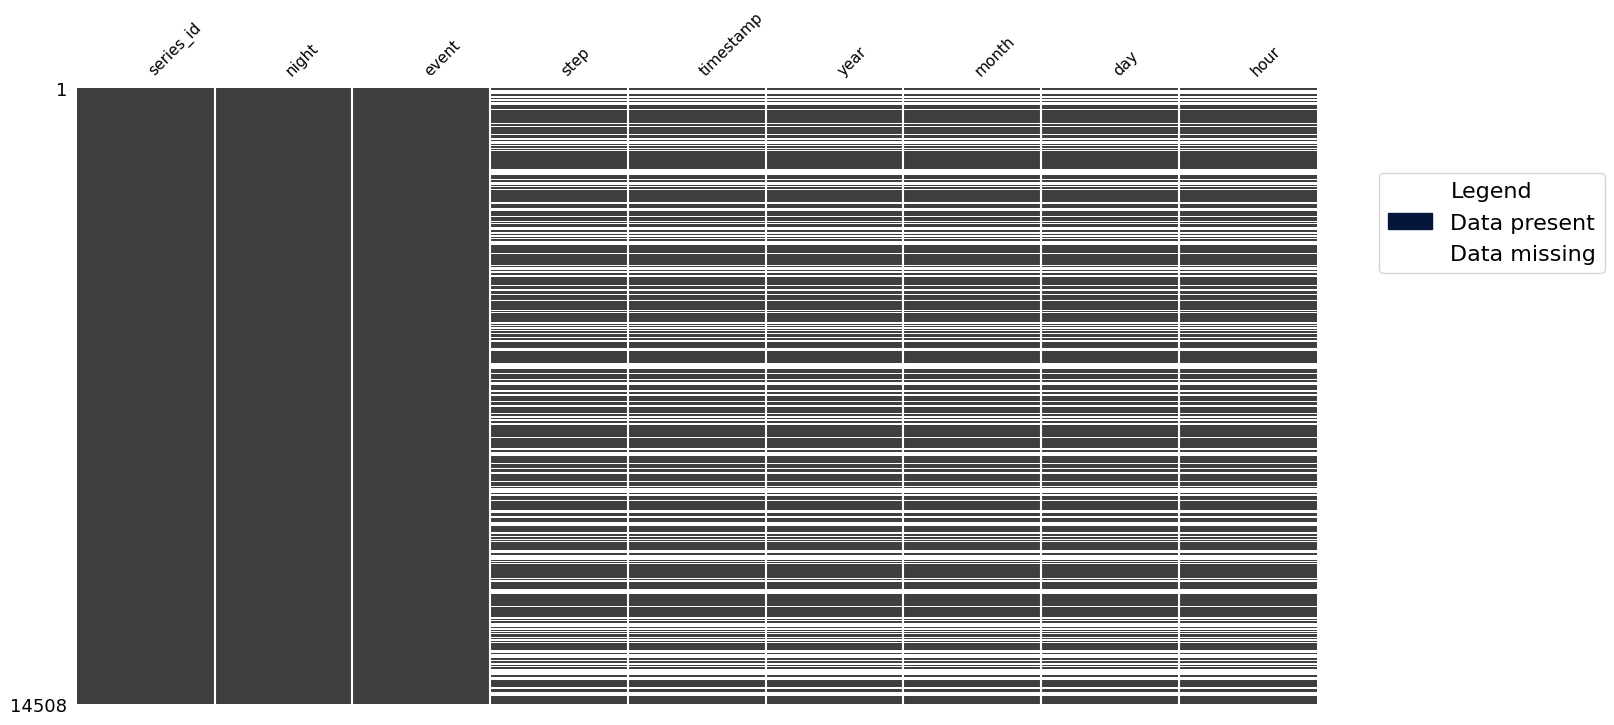

In [56]:
import matplotlib.patches as mpatches
# Plot the missing values in the 'train_events' DataFrame
fig, ax = plt.subplots(figsize=(16, 8))
msno.matrix(train_events, sparkline=False, ax=ax, fontsize=11)

# Set the background color for data present and missing data
ax.set_facecolor('#05163a')  # Data present color
ax.patch.set_edgecolor('#05163a')  # Border color
ax.grid(False)  # Turn off grid for better visibility

# Create legend with blue and white patches
blue_patch = mpatches.Patch(color='#05163a', label='Data present')
white_patch = mpatches.Patch(color='#FFFFFF', label='Data missing')
legend = plt.legend(loc=[1.05, 0.7], handles=[blue_patch, white_patch], fontsize=16, frameon=True, title="Legend")
plt.setp(legend.get_title(), fontsize='16')  # Set legend title fontsize

plt.show()

In [57]:
# what's the percentage of missing data? take 'step' column as proxy for all
print(f"The 'train_events' DataFrame has approx. {(round(train_events['step'].isna().sum()/train_events.shape[0],2)*100)}% missing data.")

The 'train_events' DataFrame has approx. 34.0% missing data.


#### Observations

- There are no missing values in the `train_series` file.

- In the `train_events` file, there are missing values in the columns 'step', 'timestamp', 'year', 'month', 'day', and 'hour.'
    - These columns are directly related to each other, with one step consisting of 5 seconds, and the timestamp recording the beginning of that step.
    - The 'year', 'month', 'day', and 'hour' columns were obtained from the timestamp column.
    - The missing value counts are the same for these columns, occurring in the same rows for all columns.
    - The missing values amount to 34% of the data, indicating a substantial proportion. Deciding how to handle them will be crucial for the model.

In [58]:
# how many unique series (patients) are there?
train_events['series_id'].nunique()
print(f"The number of unique series (participants) is {train_events['series_id'].nunique()}.")

The number of unique series (participants) is 277.


In [59]:
# create dataframe with percentage of missing values of 'step' for each 'series_id'
series_step_nas = train_events.groupby('series_id')['step'].apply(lambda x: x.isna().sum()/len(x)*100).to_frame()
series_step_nas.columns = ['percentage_missing_step']
series_step_nas.head()

,percentage_missing_step
series_id,
038441c925bb,17.391304
03d92c9f6f8a,78.378378
0402a003dae9,25.000000
04f547b8017d,43.243243
05e1944c3818,12.500000


In [60]:
# what is the distribution of missing values? (basic stats)
series_step_nas.describe().T

,count,mean,std,min,25%,50%,75%,max
percentage_missing_step,277.0,31.320512,30.386764,0.0,8.333333,19.444444,50.0,100.0


In [61]:
# how many series have 0% of missing values? how many have 100%?
print(f"Series with 0% missing values: {series_step_nas[series_step_nas['percentage_missing_step']==0].shape[0]}")
print(f"Series with 100% missing values: {series_step_nas[series_step_nas['percentage_missing_step']==100].shape[0]}")

Series with 0% missing values: 37
Series with 100% missing values: 8


In [62]:
# Ensure the directory exists, create it if not
output_folder = "html_files"
os.makedirs(output_folder, exist_ok=True)

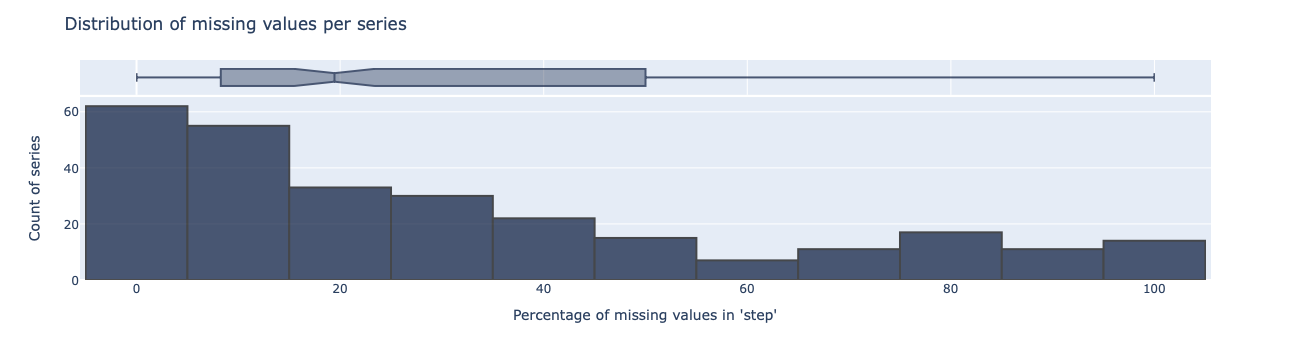

In [66]:
# Create a histogram using Plotly
fig = px.histogram(
    series_step_nas,
    x='percentage_missing_step',
    nbins=20,
    color_discrete_sequence=['#05163a'],
    marginal='box',
)

fig.update_layout(
    title='Distribution of missing values per series',
    xaxis=dict(title='Percentage of missing values in \'step\''),
    yaxis=dict(title='Count of series'),
)

fig.update_traces(marker=dict(line=dict(width=2, color='Black')), opacity=0.7)

# Save the plot as a standalone HTML file in the specified folder
html_file_path = os.path.join(output_folder, "histogram_plot1.html")
fig.write_html(html_file_path)

# Display the plot in the notebook
fig.show()

Observations:
- There are a total of 277 series.

- Using `step` as a proxy for all missing values (considering the consistent pattern across the 6 columns), the distribution of missing values per series ranges from 0% (complete series) to 100% (all values missing).

- Specifically, 37 series have no missing values, and 8 series have all missing values.

- The remaining series fall within this range, with the median percentage of missing values at 20% (i.e., half of the series have up to 20% of the data missing).

## Resampling data to 1-Minute intervals
Dataset Characteristics
- The accelerometer data is recorded at 5-second intervals, resulting in a large dataset with high temporal granularity.

Evaluation Requirements
- The evaluation metric requires predicting events with a precision of 1 minute.
- The average precision is calculated over various timestamp error tolerance thresholds.

Reduction of Memory Usage and Processing Complexity
- The dataset, with recordings every 5 seconds, consumes a significant amount of memory and poses challenges in processing.
- Resampling the data to 1-minute intervals allows for a substantial reduction in both memory usage and processing complexity.

Focus on Relevant Information
- The key sleep events (onset and wakeup) are expected to occur within relatively larger time intervals.
- Taking the absolute maximum value occurring in a minute provides a representative summary of the entire range of values during that interval.

Conclusion
Resampling the data to 1-minute precision by taking the absolute maximum value aligns with the evaluation requirements, reduces memory usage and processing complexity, and focuses on relevant information for the detection of sleep events in the accelerometer series.

In [67]:
def aggregate_series(df, num_series=-1):
    df_list = []
    unique_series_id = df.series_id.unique()

    if num_series == -1:
        unique_series_id = df.series_id.unique()
    else:
        if 0 < num_series <= len(unique_series_id):
            unique_series_id = df.series_id.unique()[:num_series]
        else: 
            print(f'num_series must be less than or equal to {len(unique_series_id)}')
            return None

    total_series = len(unique_series_id)

    times = []

    for idx, series_id in enumerate(unique_series_id, 1):
        series_data = df[df['series_id'] == series_id].set_index('timestamp')
        start_time = time.time()
        window = series_data.resample('1T').agg({
            'anglez': lambda x: x.loc[x.abs().idxmax()] if not x.empty else np.nan,
            'enmo': 'max'
        })

        window['series_id'] = series_id

        df_list.append(window)

        end_time = time.time()
        elapsed_time = end_time - start_time
        times.append(elapsed_time)
        print(f"Processing series_id: {series_id}. {idx}/{total_series} series completed. Time taken: {elapsed_time:.2f} seconds. Avg time: {np.mean(times):.2f} seconds. Expected total time: {np.mean(times)*total_series/60:.2f} minutes.")
    df_new = pd.concat(df_list)

    df_new.reset_index(inplace=True)
    return df_new

def fix_arrays(df):
    def first_element(cell):
        if isinstance(cell, (list, np.ndarray)):
            print('Array detected and replaced with first element.')
            return cell[0]
        else:
            return cell
    return df.applymap(first_element)

def fix_nans(df):
    number_of_nans = df.isna().sum()
    df.dropna(inplace=True)
    print(f'Dropped {number_of_nans} rows with NaNs.')
    return df

def to_parquet(df, path):
    df.to_parquet(path)
    print(f'Saved to {path}.')

def main(df, save_path, num_series=-1):
    # df = pd.read_parquet('../data/memory_optimised_data/train_series_mem_optimised.parquet')
    df_ = df.copy()
    df_ = aggregate_series(df_, num_series)
    df_ = fix_arrays(df_)
    df_ = fix_nans(df_)
    to_parquet(df_, save_path)
    return df_

In [68]:
df = pd.read_parquet(path + 'memory_optimised_data/train_series_mem_optimised.parquet')
train_series = main(df, path + 'memory_optimised_data/train_series_aggregated.parquet')

NameError: name 'time' is not defined

In [ ]:
# export sleep dataframe as parquet file
# sleep.to_csv(path + 'memory_optimised_data/sleep_mem_optimised.csv', index=False)